In [60]:
import sys
import pandas as pd
import numpy as np
import requests
import os
import datetime
from dateutil.relativedelta import relativedelta
import pytz
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
from scipy.stats import linregress
import json
import math
import ast
from sys import stdout as out
from fpdf import FPDF
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def get_dev_info(device, address):
    
    r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    
    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']
    
    # get devid by serial name
    r1 = requests.get(
        url=address + "/api/tenant/devices?deviceName=" + device,
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    label = r1['label']
    devid = r1['id']['id']
    r1 = requests.get(
        url=address + "/api/device/" + devid + "/credentials",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    devtoken = r1['credentialsId']

    r2 = requests.get(url=address + "/api/plugins/telemetry/DEVICE/"+devid+"/values/attributes",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    key_to_find = 'key'
    value_to_find1 = 'latitude'
    value_to_find2 = 'longitude'

    # Iterate through the list of dictionaries
    for dictionary in r2:
        if dictionary.get(key_to_find) == value_to_find1:
            lat = dictionary['value']
        if dictionary.get(key_to_find) == value_to_find2:
            lon = dictionary['value']
            
    
    # lat = r2[14]['value']
    # lon = r2[15]['value']
    return devid,devtoken,acc_token,label,lat,lon


def read_data(acc_token, devid, address, start_time, end_time, descriptors):

        
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    
    if r2:
        df = pd.DataFrame([])
        
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1['ts'] = df1['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)            
            
            df = pd.concat([df, df1], axis=1)

        if df.empty:
            df = pd.DataFrame([])
        else:
            for col in df.columns:
                df[col] = df[col].astype('float64')
    else:
        df = pd.DataFrame([])
        # print('Empty json!')
    return df

In [66]:
def getPwrTmp(address, acc_token, devid, start_time, end_time):
    desc = 'cnrgA,cnrgB,cnrgC,outTemp'
    df = read_data(acc_token, devid, address,  start_time, end_time, desc)
    if not df.empty:
        df = df.sort_index()
        
        # df['ts'] = pd.to_datetime(df['ts'], unit='ms')
        # df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
    return df

def plotnrgtmp(df, label, device, assetname):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Bar Plot for Energy Consumption
    ax1.bar(df.index, df['nrg'], color='green', label='Energy Consumption')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Energy Consumption (kWh)')
    ax1.set_title('Energy & Temperature '+assetname+','+label+'('+device+')')
    ax1.tick_params(axis='y', labelcolor='green')
    # ax1.set_xticklabels(df.index, rotation=90, ha='right')
    date_format = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    # Create a second y-axis for Temperature
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['outTemp'], color='red', marker='o', label='Temperature')
    ax2.set_ylabel('Outdoor Temperature', color='red')

    # Show the legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # save the plot
    plt.savefig('nrgTmp_'+label+'('+device+').png')

def scatterplot(df, label, device, assetname):
    correlation_matrix = df.corr()
    # correlation_energy_temperature = correlation_matrix['nrg']['outTemp']

    plt.figure(figsize=(10, 6))
    plt.scatter(df['outTemp'], df['nrg'],color='b')
    # Regression Line Fit
    slope, intercept, r_value, _, _ = linregress(df['outTemp'], df['nrg'])
    line = slope * df['outTemp'] + intercept

    plt.plot(df['outTemp'], line, color='red', label=f'Regression Line (R-squared={r_value**2:.2f})')

    plt.title('Scatter Plot '+assetname+','+label+'('+device+')')
    plt.xlabel('Outdoor Temperature (Celsius degrees)')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend
    # save the plot
    plt.savefig('scatter_'+label+'('+device+').png')


In [64]:
address = 'https://mi6.meazon.com'
start_time = '1702846800000'
end_time = '1705442400000'


r = requests.post(address + "/api/auth/login",
                    json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()

acc_token = 'Bearer' + ' ' + r['token']


entityId = '4795fc10-5b7f-11ee-b2c9-653b42f73605' # DEDDHE ATHINAS
r1 = requests.get(url=address + "/api/entityGroup/"+entityId+"/entities?pageSize=1000&page=0",headers={'Content-Type': 'application/json', 
'Accept': '*/*', 'X-Authorization': acc_token}).json()

C:\Users\EmilyP\AppData\Local\Temp\ipykernel_6576\3778436330.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


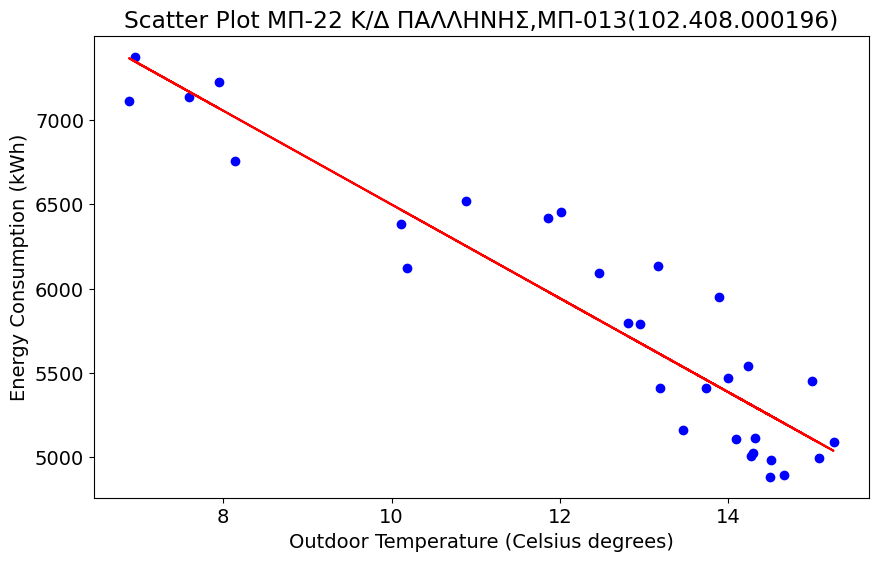

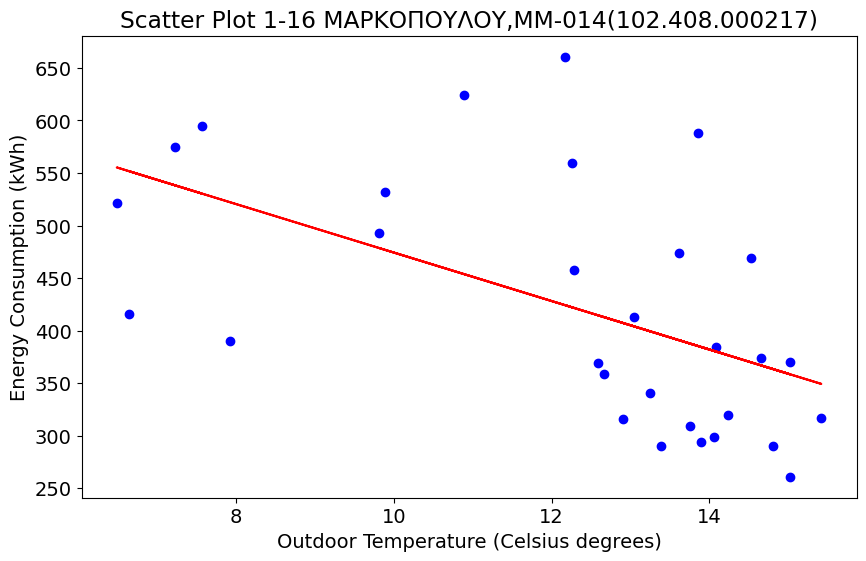

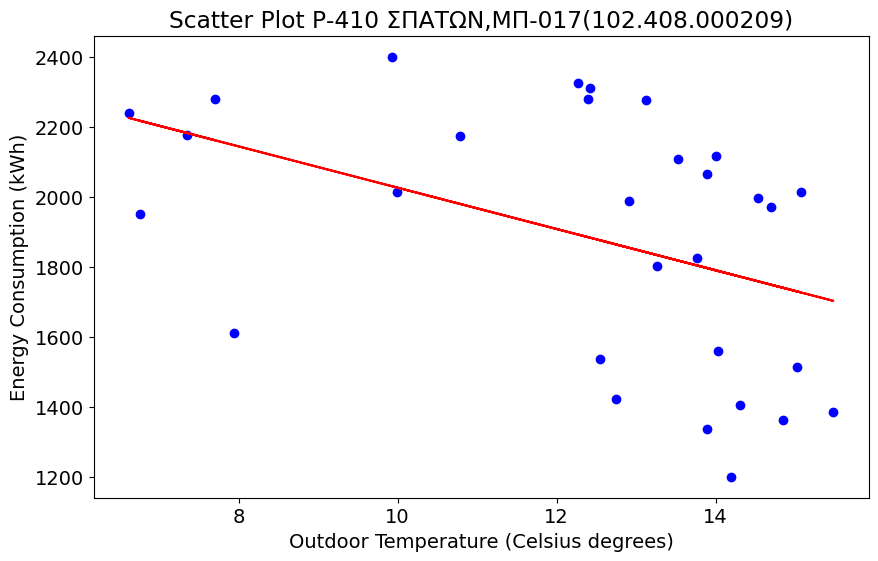

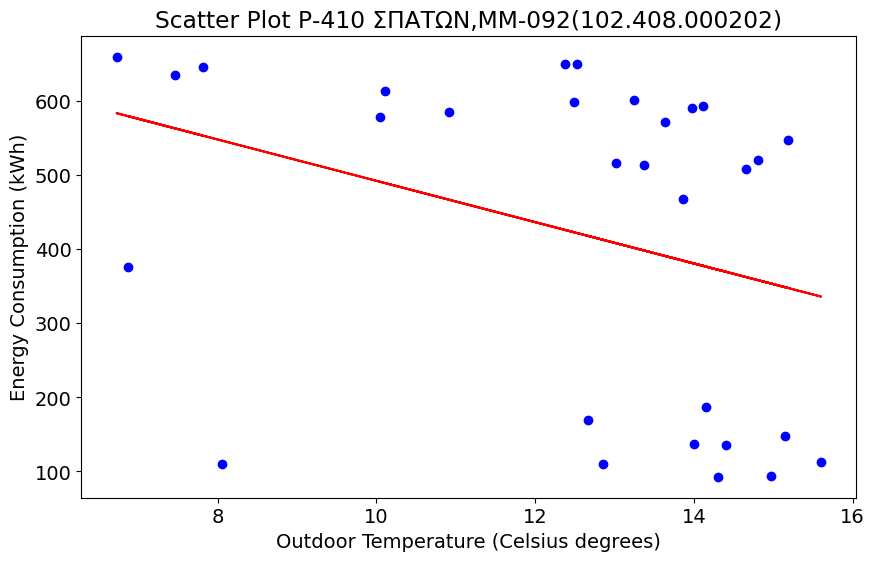

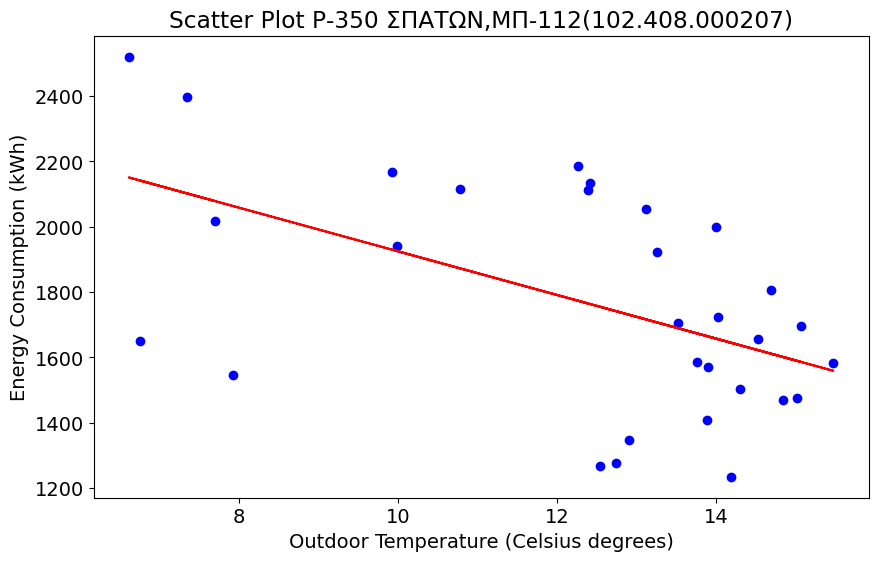

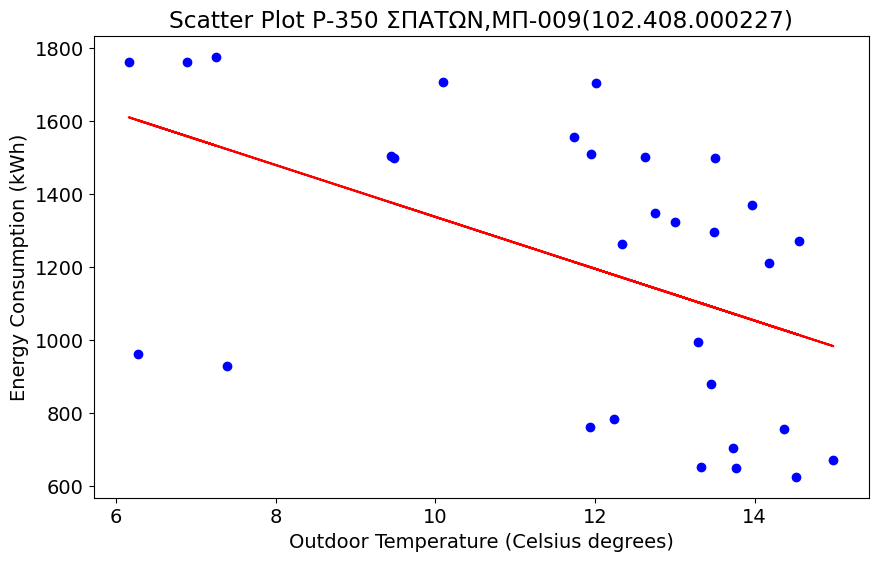

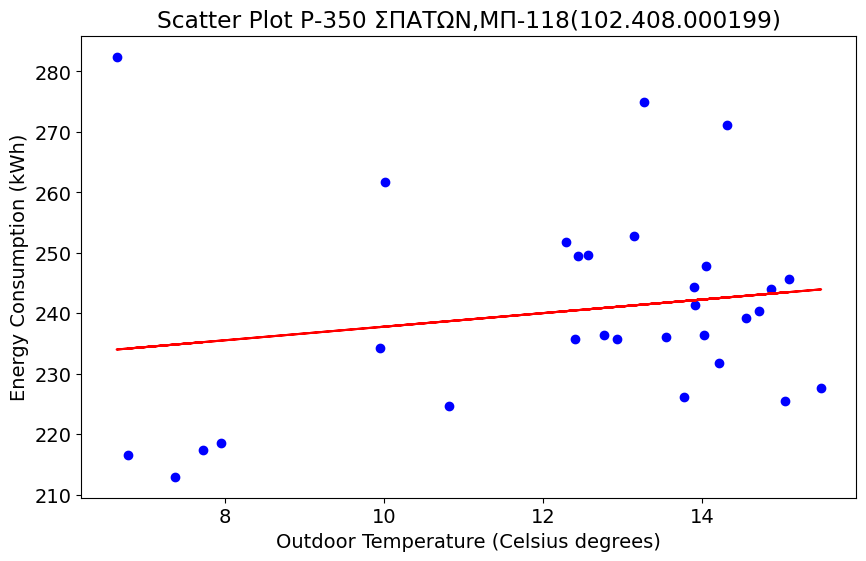

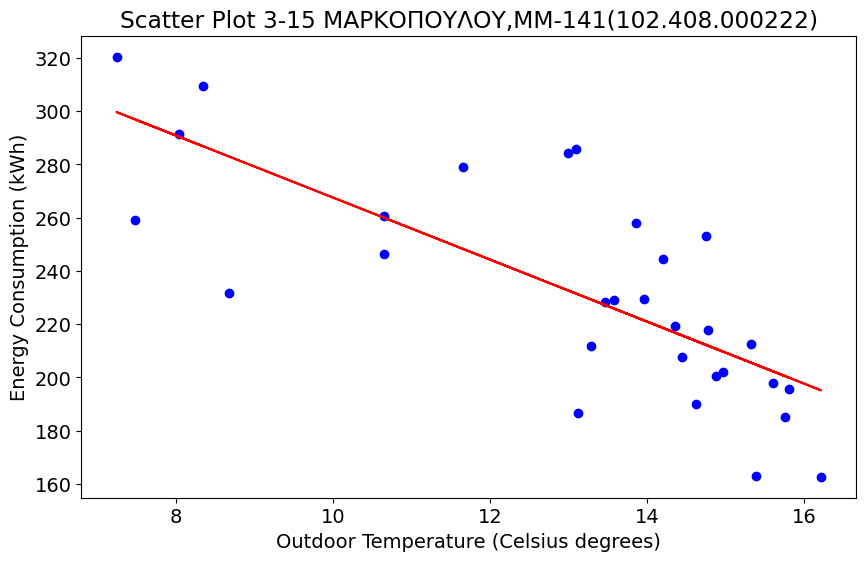

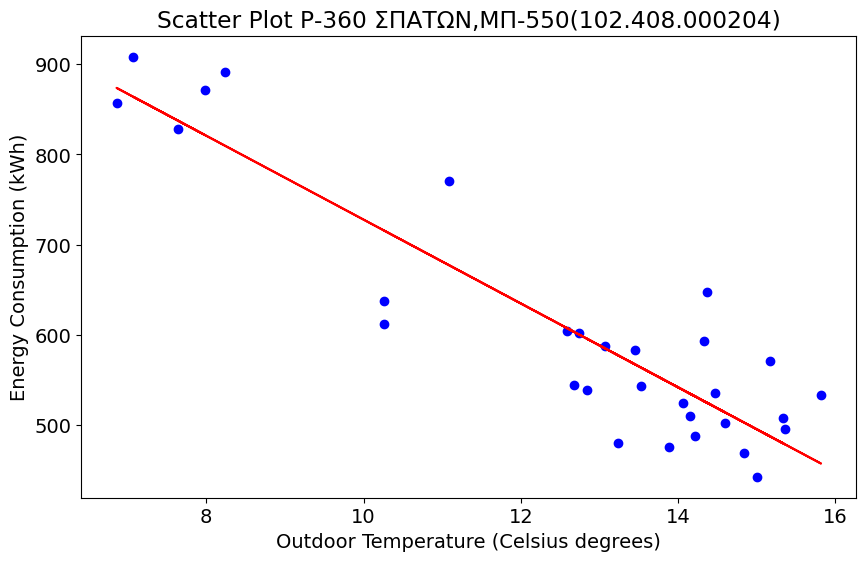

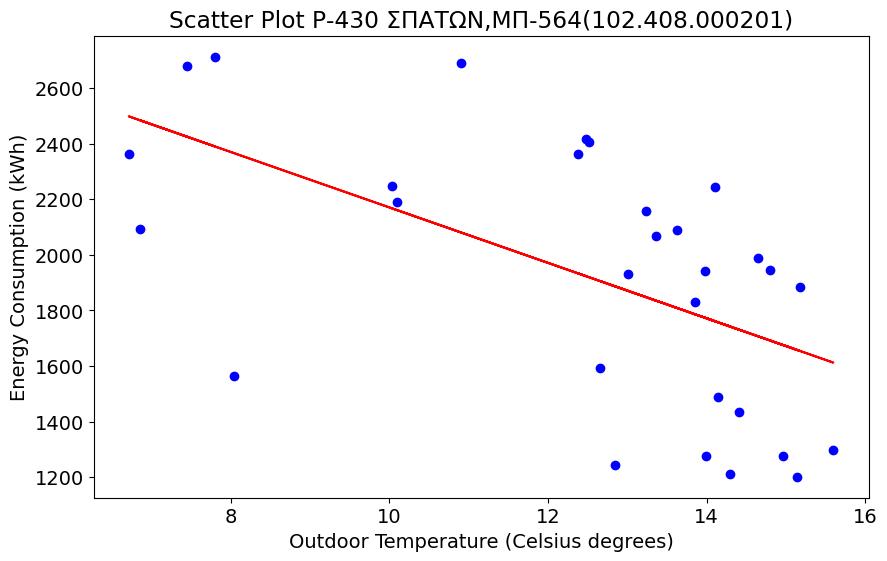

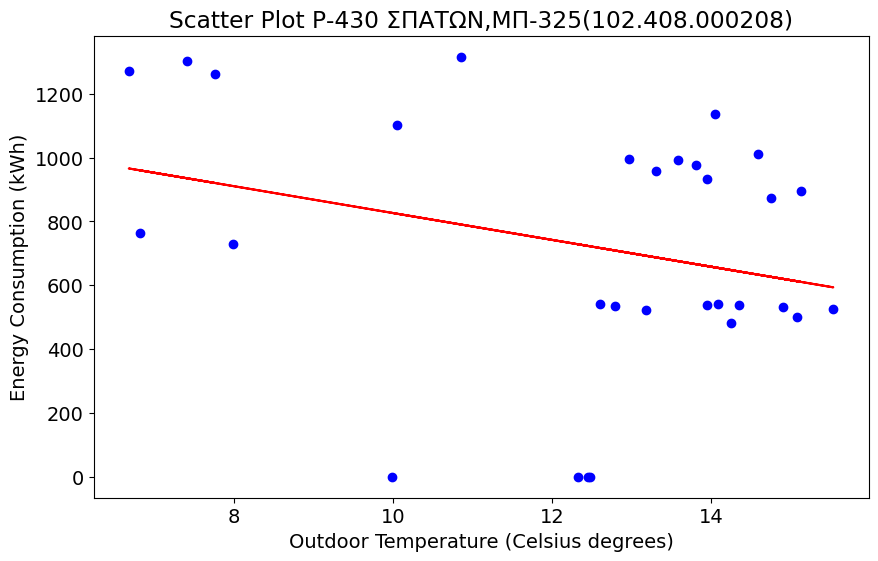

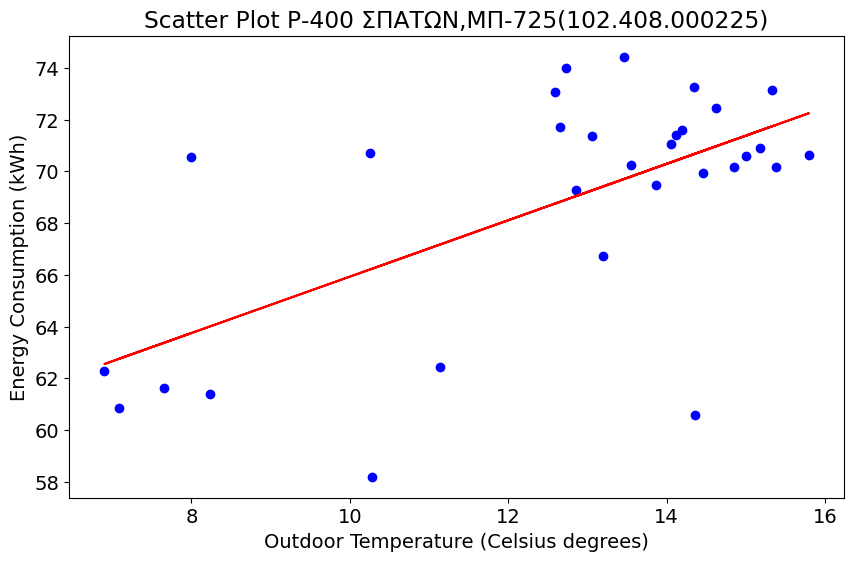

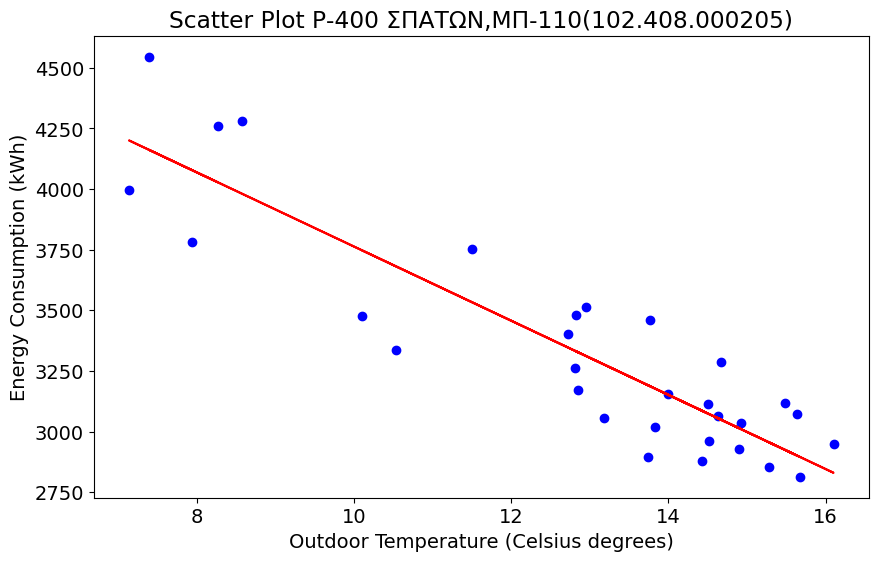

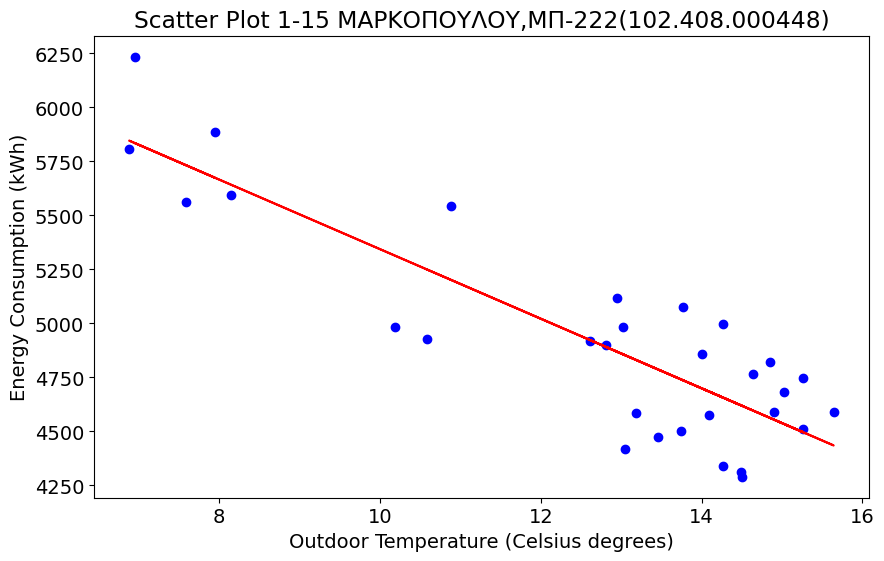

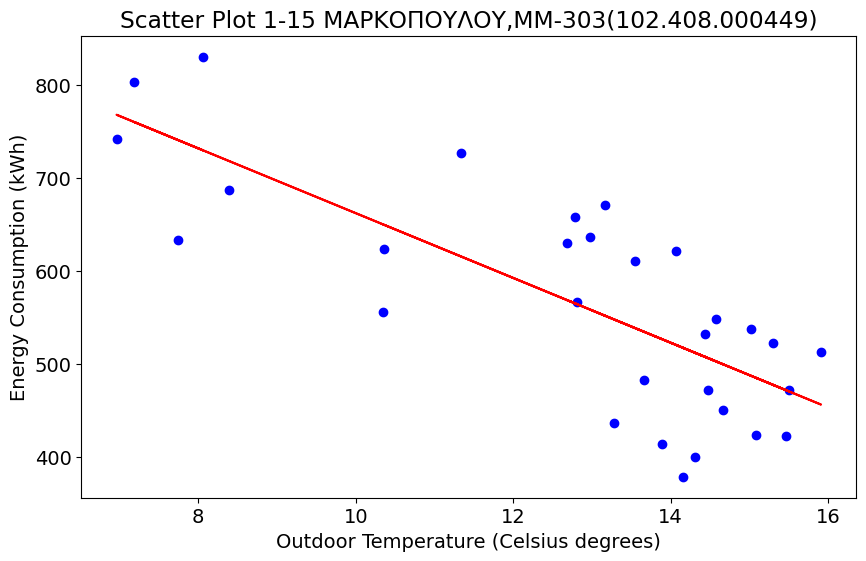

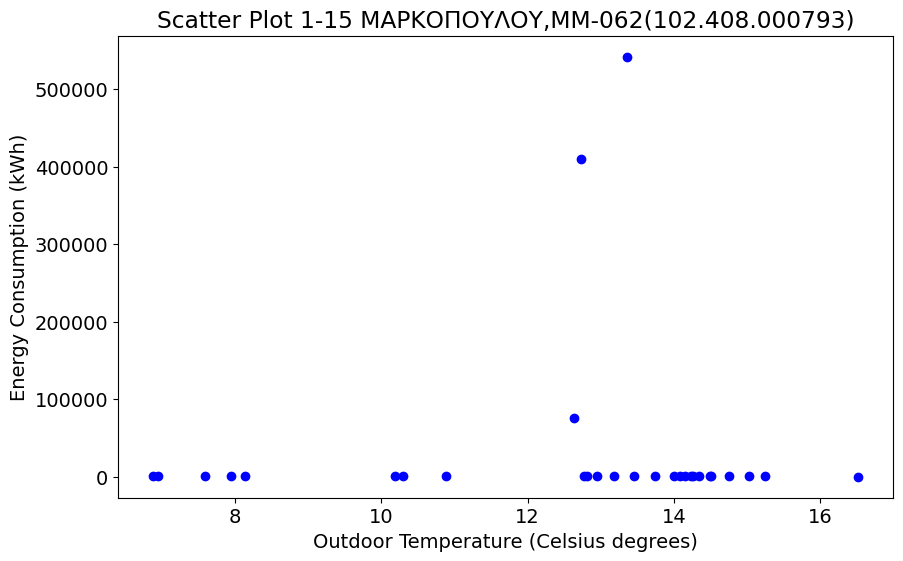

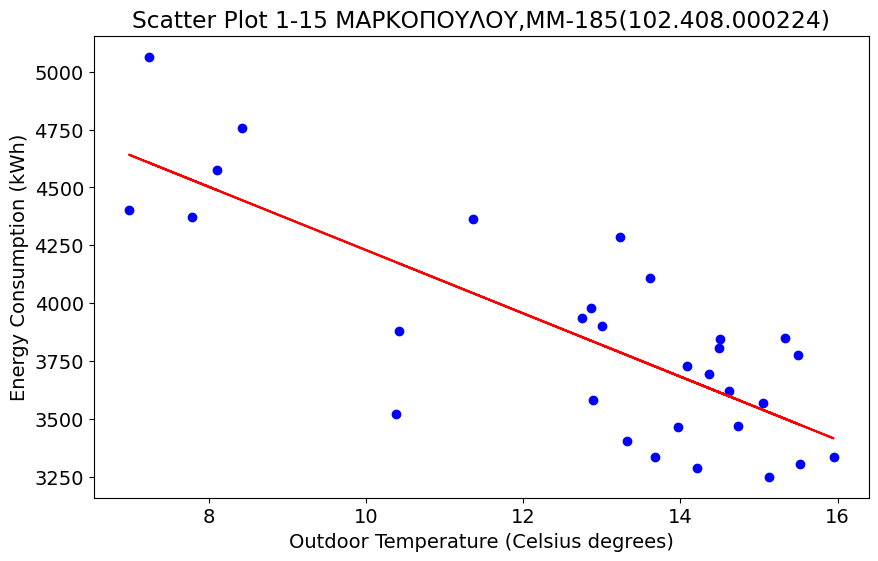

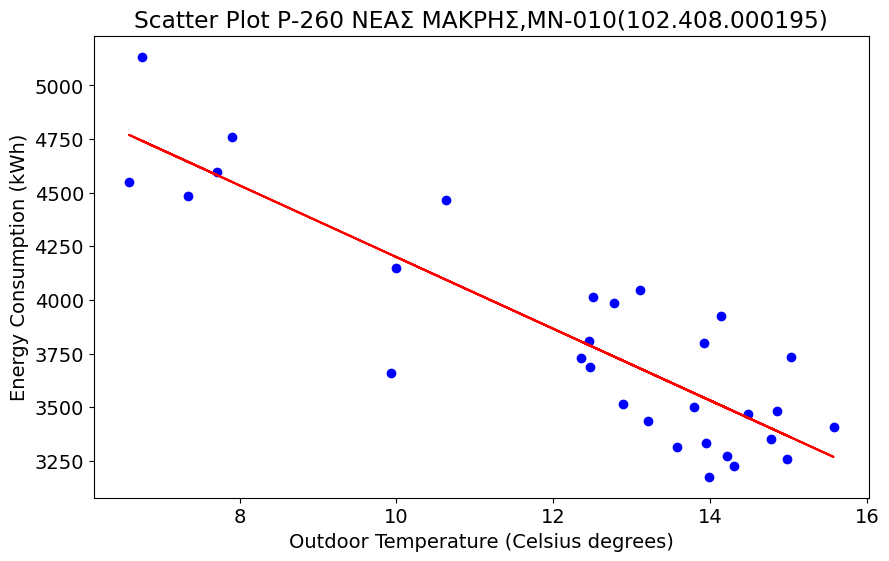

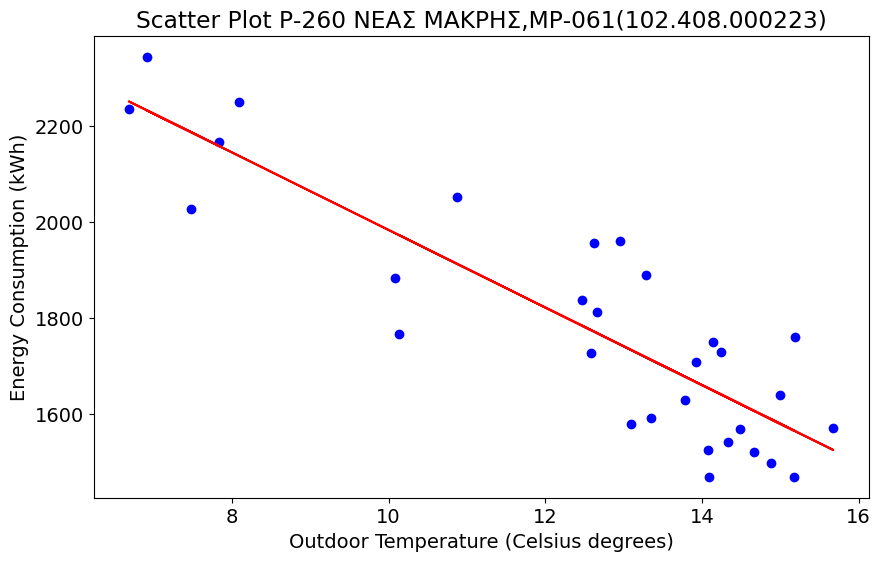

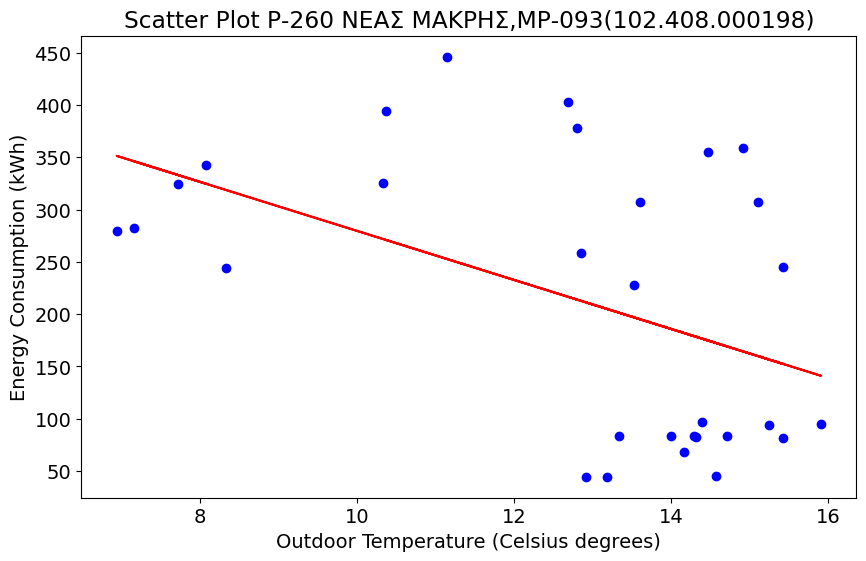

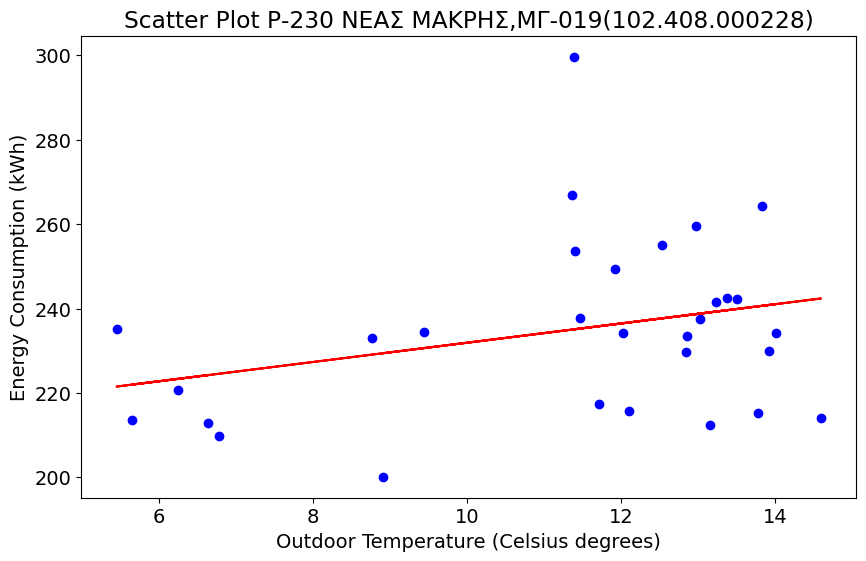

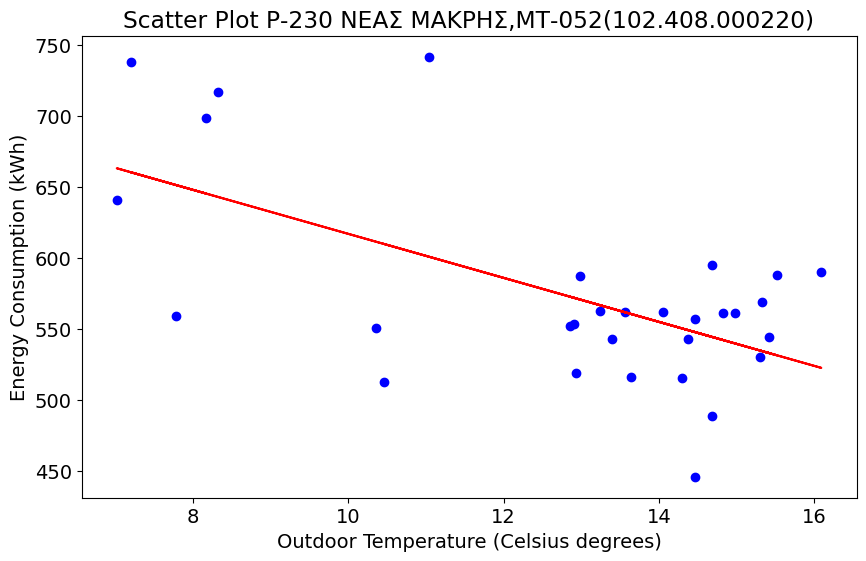

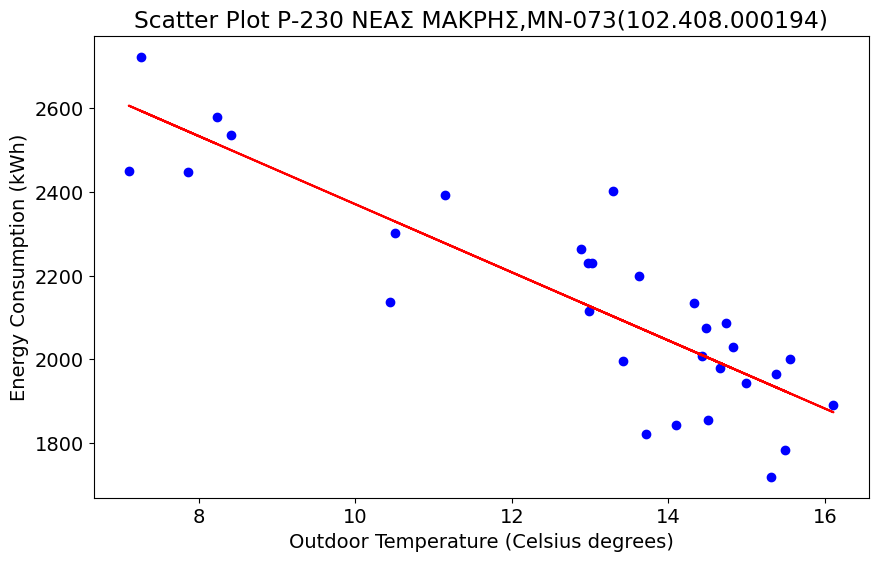

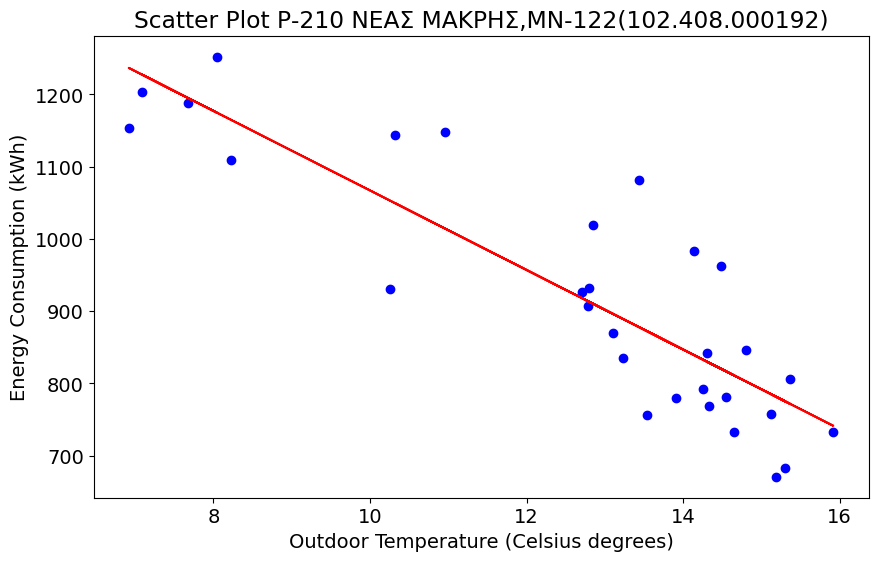

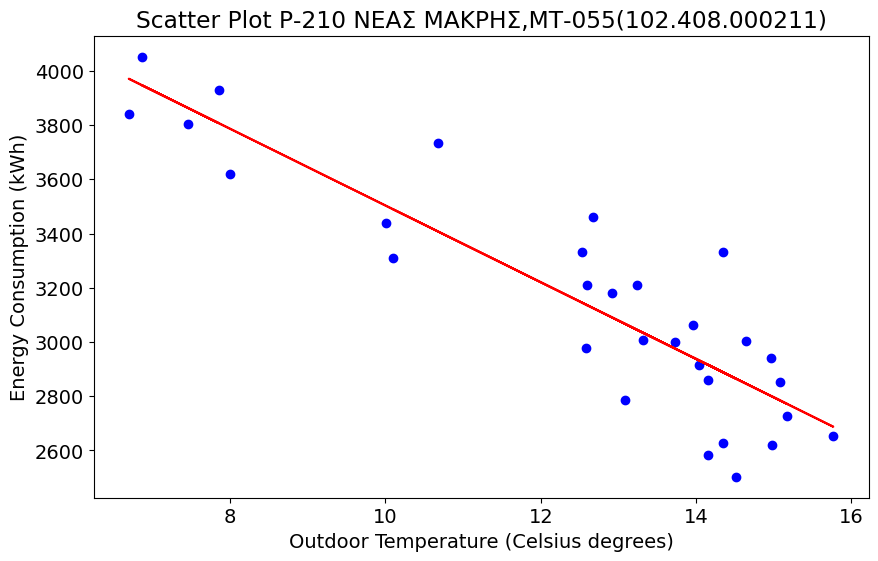

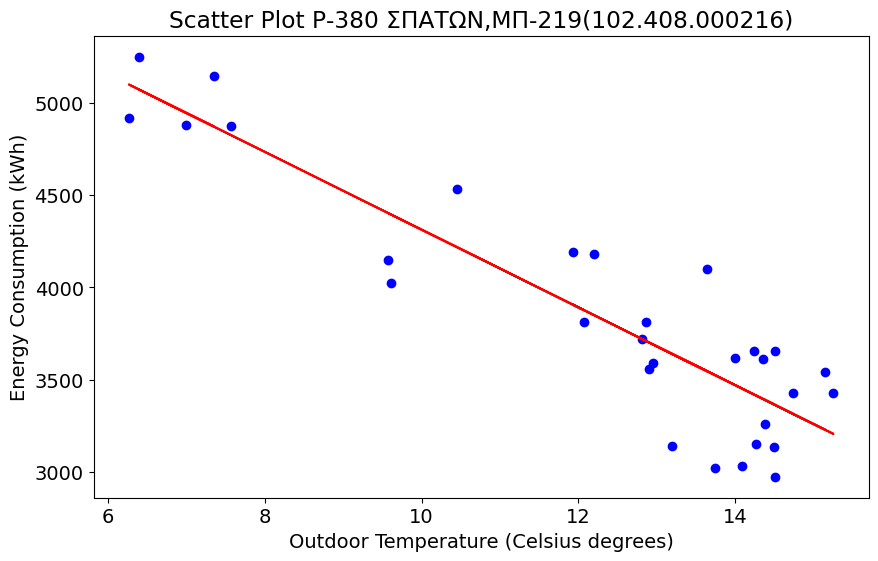

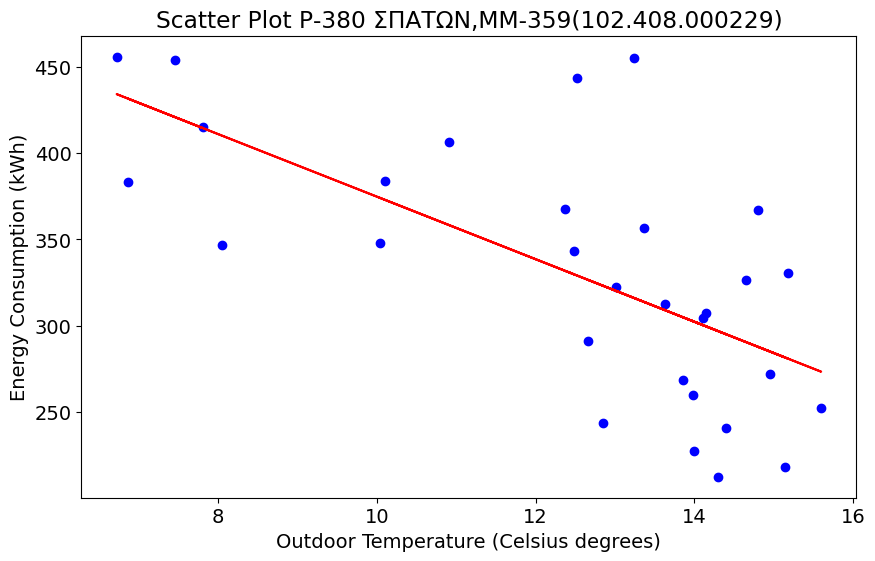

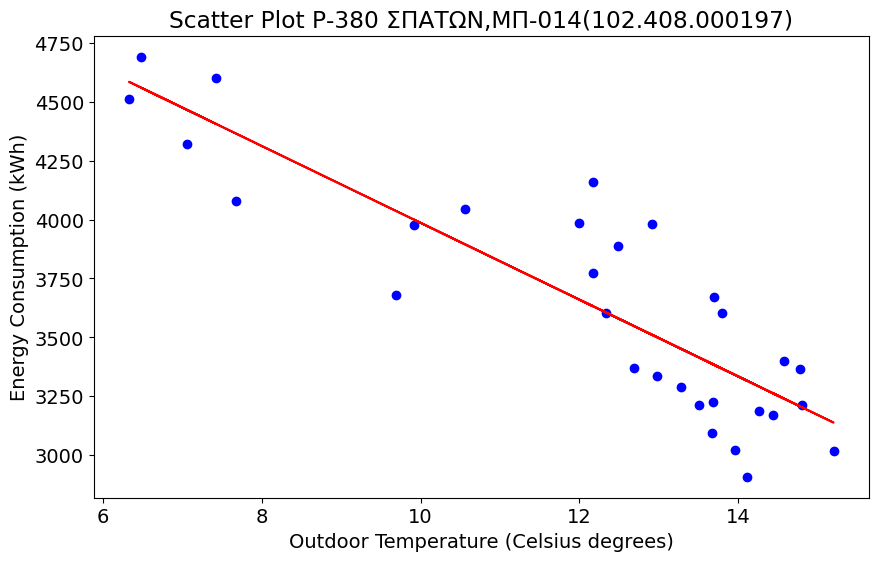

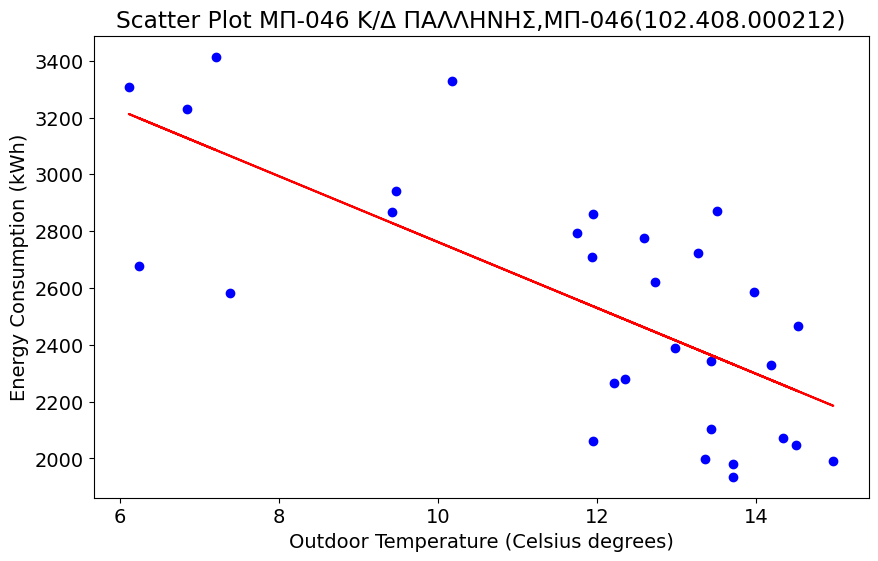

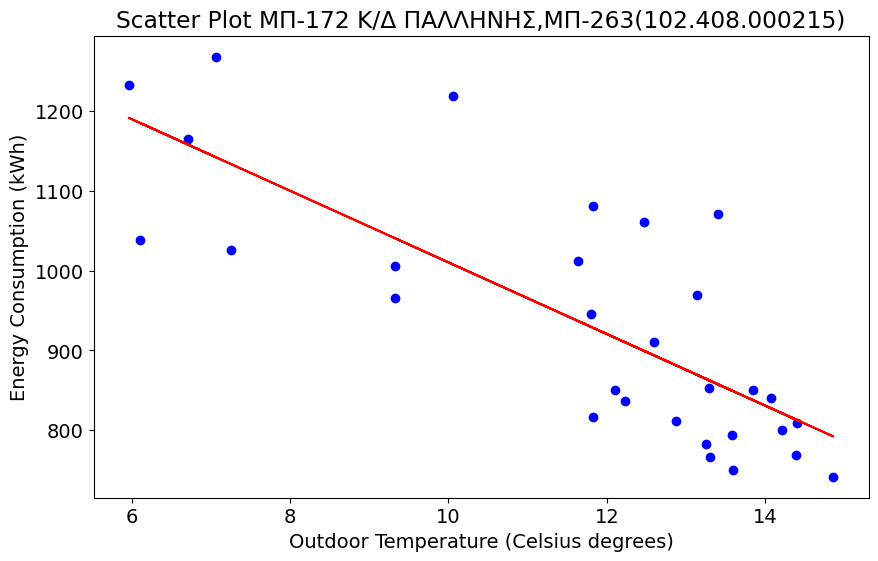

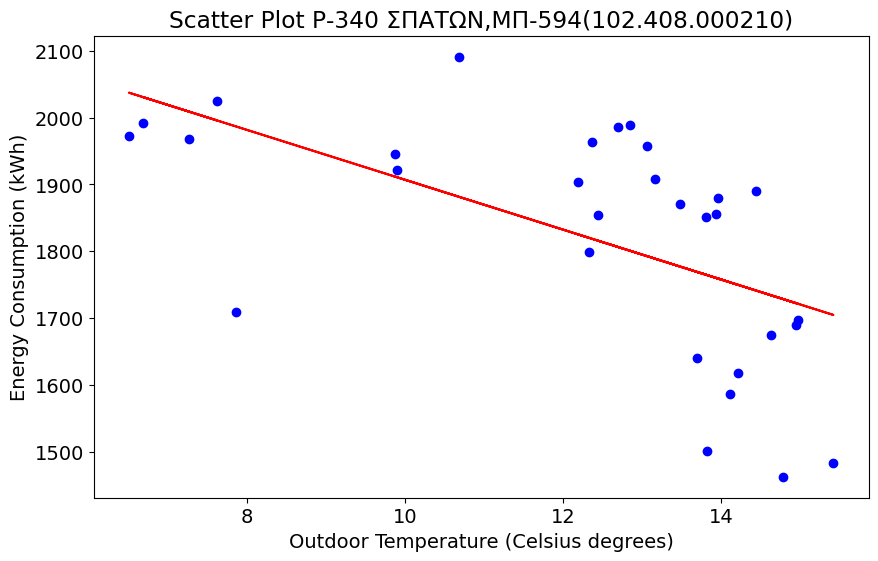

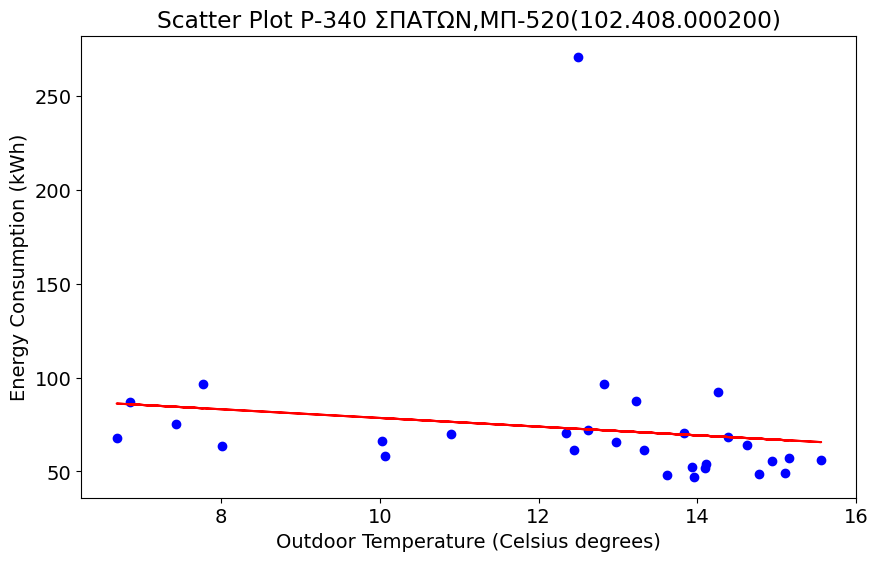

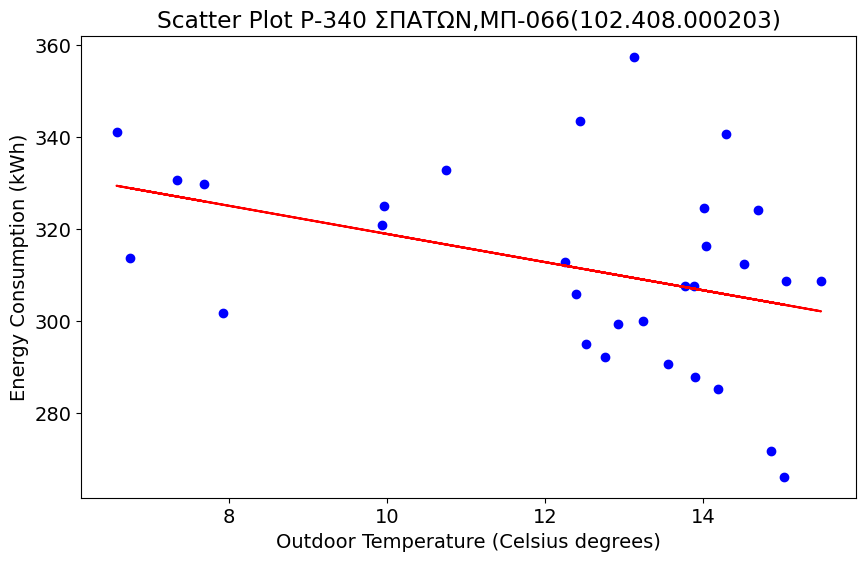

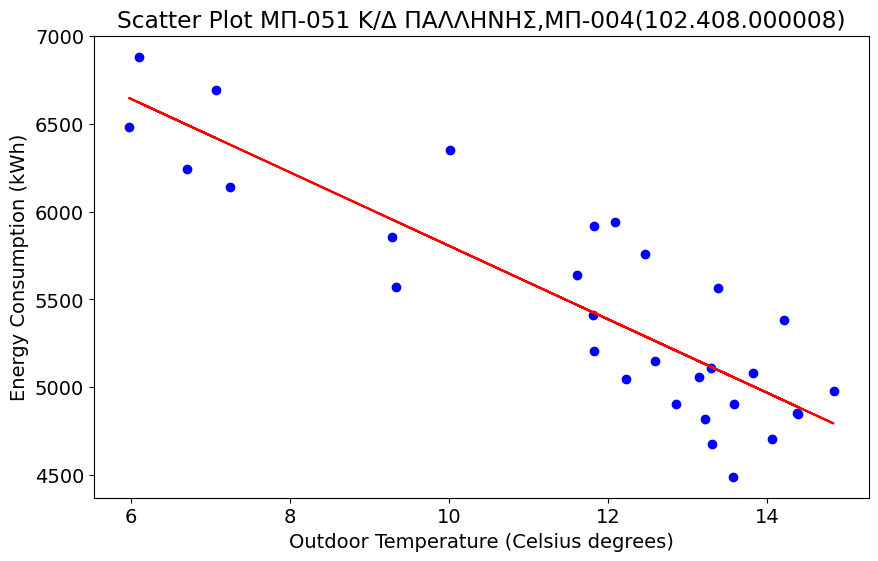

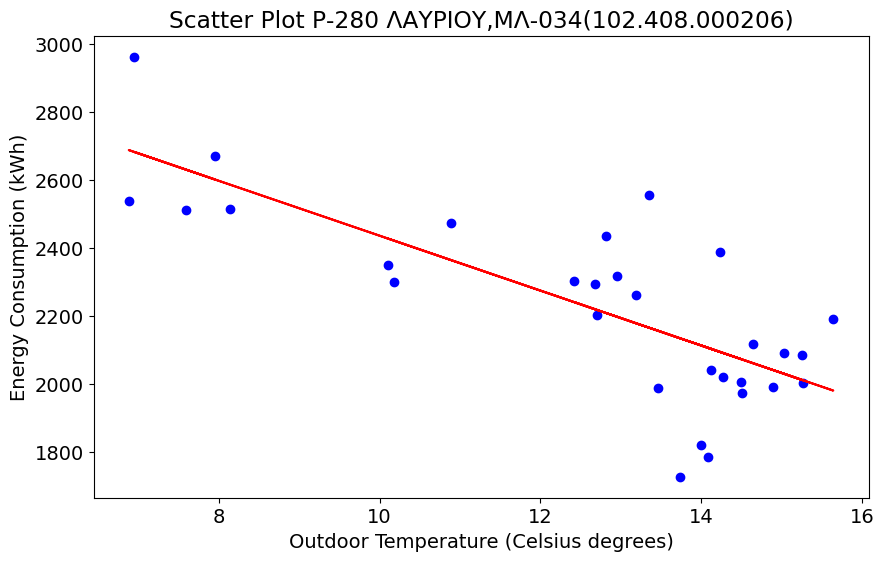

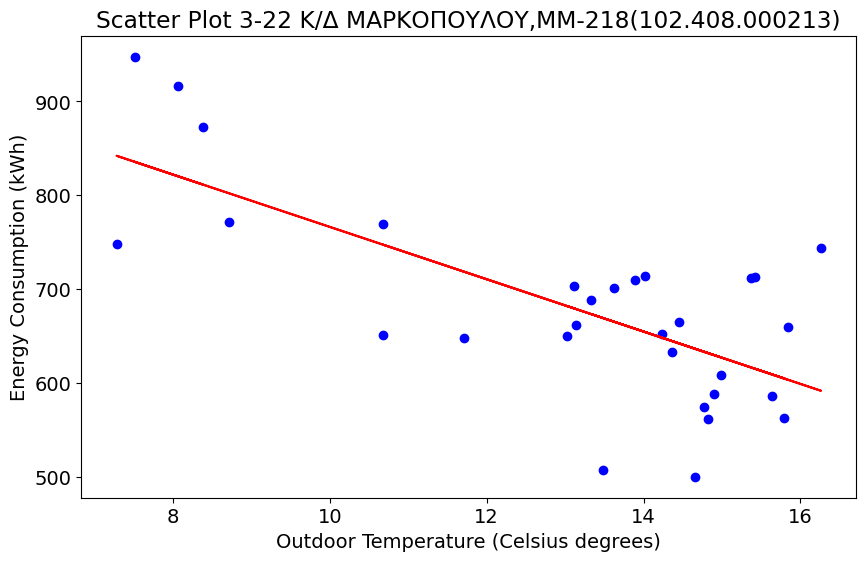

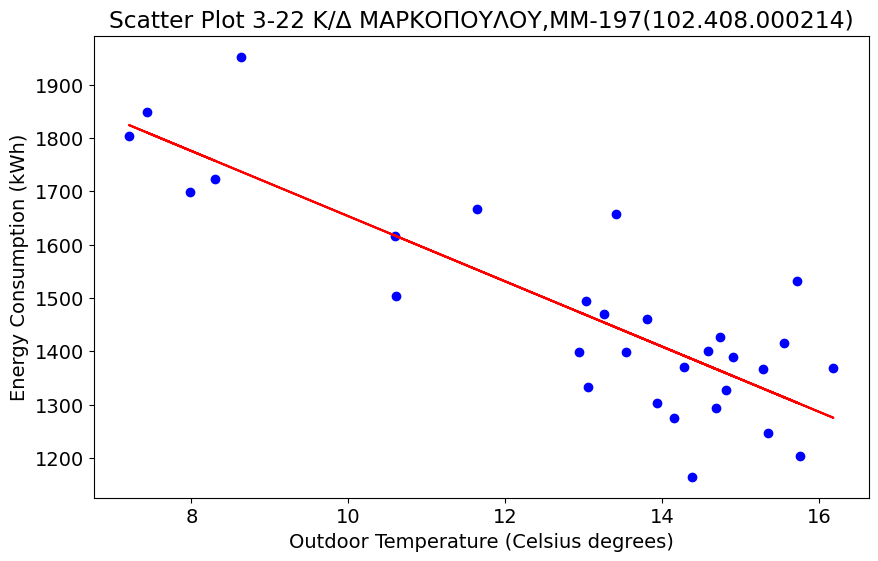

In [65]:
# os.chdir('plots')
for i in range(0,len(r1['data'])):
# for i in range(0,1):
     #   os.chdir('/home/azureuser/deddhePDF/')
      assetid = r1['data'][i]['id']['id']
      assetname = r1['data'][i]['name']
      # print(assetname)
      if assetname[0]!='0':
         r2 = requests.get(url=address + "/api/relations/info?fromId="+assetid+"&fromType=ASSET",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
         for j in range(0, len(r2)):
            device = r2[j]['toName']
            if device[:3]=='102':
               [devid, _, acc_token,label, lat, lon] = get_dev_info(device, address)
               df = getPwrTmp(address, acc_token, devid, start_time, end_time)
               df['totalnrg'] = df['cnrgA']+df['cnrgB']+df['cnrgC']
               df['nrg'] = df['totalnrg']-df['totalnrg'].shift()
               
               df = df.drop(['cnrgA','cnrgB','cnrgC','totalnrg'],axis=1)

               df = df.resample('1H').agg({'nrg':'sum','outTemp':'mean'})
               df = df.dropna()
               
               # remove 1st row and divide by 1000 to get kWh
               df = df.iloc[1:]
               df['nrg'] = df['nrg']/1000


               # resample daily
               df = df.resample('1D').agg({'nrg':'sum','outTemp':'mean'})

               # plotnrgtmp(df, label, device, assetname)
               scatterplot(df, label, device, assetname)

               # # search for nested devices
               # r3 = requests.get(url=address + "/api/relations/info?fromId="+devid+"&fromType=DEVICE",headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
               # for k in range(0, len(r3)):
               #    device = r3[k]['toName']
               #    # print('nested device:', device)
               #    [devid, _, acc_token,label, _, _] = get_dev_info(device, address)
               #    # syncal = find_alarms(acc_token, devid, start_time, end_time,syncal, device)
               #    syncal = find_alarms_dict(acc_token, devid, start_time, end_time,syncal, device, assetname,lat,lon,label)


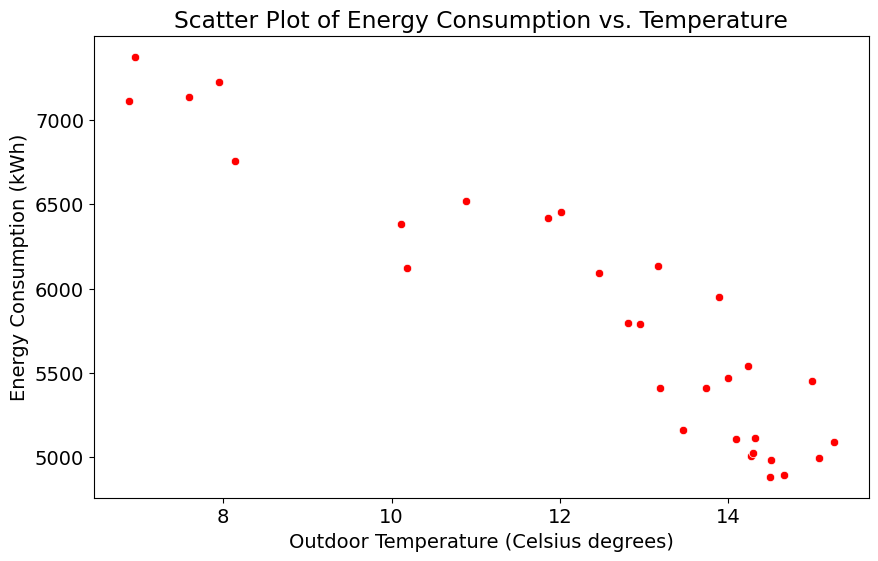

In [35]:
correlation_matrix = df.corr()
correlation_energy_temperature = correlation_matrix['nrg']['outTemp']


plt.figure(figsize=(10, 6))
sns.scatterplot(x='outTemp', y='nrg', data=df,color='r')
plt.title('Scatter Plot of Energy Consumption vs. Temperature')
plt.xlabel('Outdoor Temperature (Celsius degrees)')
plt.ylabel('Energy Consumption (kWh)')
plt.show()